In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
saliency_nc_file = "../model_cnn_20200416/neuron_saliency_cnn_20200416_000_train.nc"
sal_ds = xr.open_dataarray(saliency_nc_file)

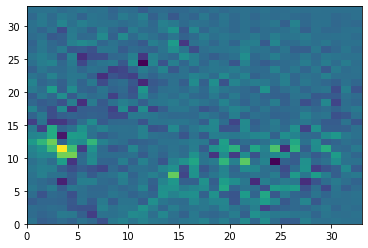

In [12]:
plt.pcolormesh(sal_ds[0, 0, :, :, 0])


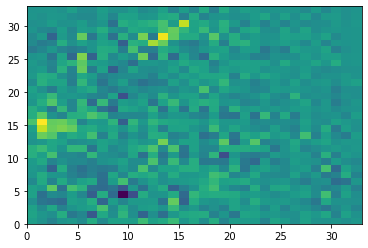

In [13]:
plt.pcolormesh(sal_ds[0, 2, :, :, 0])